To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth?tab=readme-ov-file#-installation-instructions).

**[NEW] As of Novemeber 2024, Unsloth now supports vision finetuning!**

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)

**This notebook finetunes Llama 3.2 11B to assist medical professionals in analyzing xrays, CT scans & ultrasounds.**

In [ ]:
%%capture
!pip install pip3-autoremove
!pip-autoremove torch torchvision torchaudio -y
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121
!pip install unsloth

* We support Llama 3.2 Vision 11B, 90B; Pixtral; Qwen2VL 2B, 7B, 72B; and any Llava variant like Llava NeXT!
* We support 16bit LoRA via `load_in_4bit=False` or 4bit QLoRA. Both are accelerated and use much less memory!

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a sampled version of the ROCO radiography dataset. You can access the dataset [here](https://huggingface.co/datasets/unsloth/Radiology_mini). The full dataset is [here](https://huggingface.co/datasets/eltorio/ROCOv2-radiology).

The dataset includes X-rays, CT scans and ultrasounds showcasing medical conditions and diseases. Each image has a caption written by experts describing it. The goal is to finetune a VLM to make it a useful analysis tool for medical professionals.

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
huggingface_user = user_secrets.get_secret("HF_TOKEN")
report_key = user_secrets.get_secret("wandb_api_key")

In [ ]:
from huggingface_hub import whoami
print(whoami(token=huggingface_user))

{'type': 'user', 'id': '66957888f4d5f5d06ca36462', 'name': 'Suman2004', 'fullname': 'Suman Roy', 'email': 'sumanroy202400@gmail.com', 'emailVerified': True, 'canPay': False, 'periodEnd': None, 'isPro': False, 'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/66957888f4d5f5d06ca36462/BQzGRCRMfy4WL6NSsAICJ.jpeg', 'orgs': [], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'test', 'role': 'write', 'createdAt': '2025-05-12T10:03:33.015Z'}}}


In [ ]:
from huggingface_hub import login
login(token=huggingface_user)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Suman2004/covid_chestXray", split="train", streaming=False)

In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1288
})

## Let's take a look at the dataset, and check what the 1st example shows:

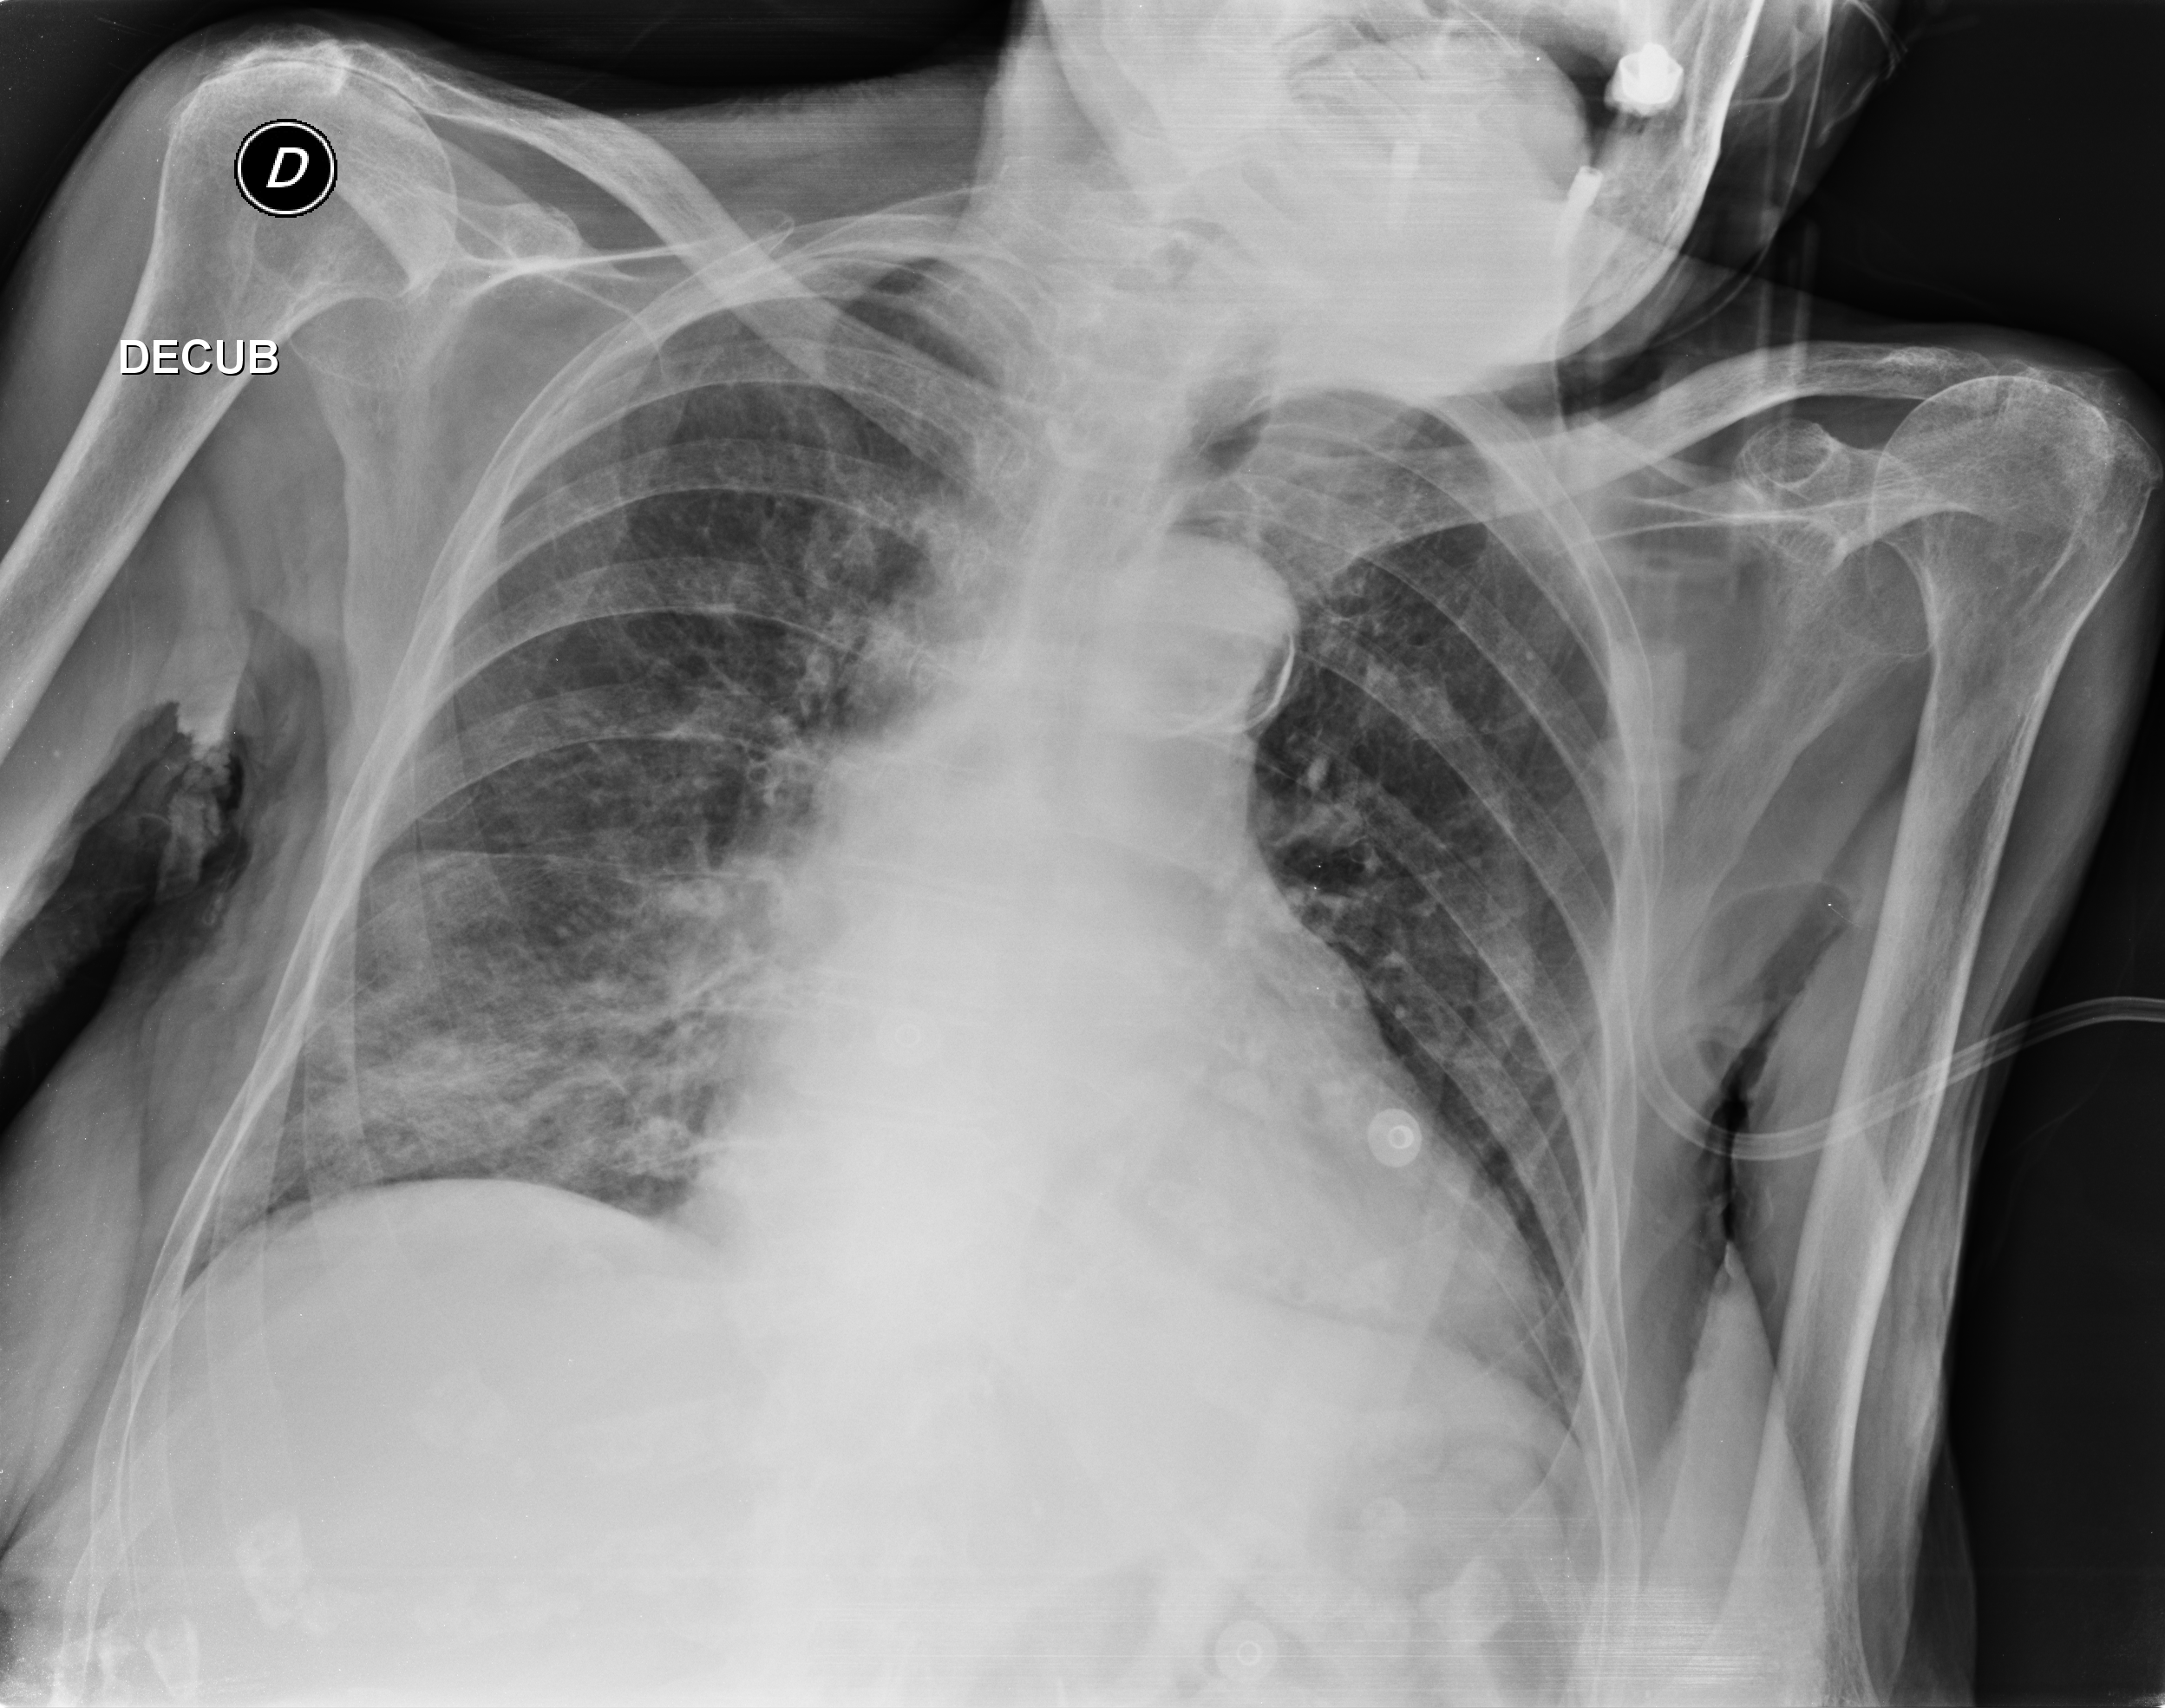

In [ ]:
dataset[0]["image"]

In [ ]:
dataset[0]["label"]

0

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```

## We will craft an custom instruction asking the VLM to be an expert radiographer. Notice also instead of just 1 instruction, you can add multiple turns to make it a dynamic conversation.

In [ ]:
instruction = '''You are an expert radiologist. Analyze the provided chest X-ray image and classify the condition into:

- COVID-19
- Normal
- Pneumonia (non-COVID)

Respond with:
1. Classification: [Condition Name]
2. Justification: [Clinical Findings]'''

# Label mapping with clinical justifications
label_data = {
    0: {
        "name": "COVID-19",
        "justification": "Bilateral ground-glass opacities predominantly in peripheral/lower zones, consistent with COVID-19."
    },
    1: {
        "name": "Normal",
        "justification": "No focal consolidations or opacities observed. Lung fields appear clear."
    },
    2: {
        "name": "Pneumonia (non-COVID)",
        "justification": "Focal consolidation with air bronchograms, suggestive of bacterial pneumonia."
    }
}

def convert_to_conversation(sample):
    label_info = label_data[sample["label"]]

    assistant_response = f"1. Classification: {label_info['name']}\n2. Justification: {label_info['justification']}"

    return {
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": instruction},
                    {"type": "image", "image": sample["image"]}
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": assistant_response}
                ]
            }
        ]
    }

## Let's convert the dataset into the "correct" format for finetuning:

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

## The first example is now structured like below:

In [ ]:
(converted_dataset[0])

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert radiologist. Analyze the provided chest X-ray image and classify the condition into:\n\n- COVID-19\n- Normal\n- Pneumonia (non-COVID)\n\nRespond with:\n1. Classification: [Condition Name]\n2. Justification: [Clinical Findings]'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2496x1969>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '1. Classification: COVID-19\n2. Justification: Bilateral ground-glass opacities predominantly in peripheral/lower zones, consistent with COVID-19.'}]}]}

## Before we do any finetuning, maybe the vision model already knows how to analyse the images? Let's check if this is the case!

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = '''🩻 Input:
[UPLOAD or INSERT chest X-ray image here]

🎯 Task:
Analyze the chest X-ray image and classify the patient's condition into one of the following categories:
- COVID-19
- Pneumonia (non-COVID)
- Normal (no infection)

🧾 Output:
Return the classification result in the following format:

Predicted Class: <COVID-19 | Pneumonia | Normal>
Confidence Score: <confidence percentage or probability>

📌 Example:
Predicted Class: COVID-19
Confidence Score: 88.7%
'''

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 500,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

**Step 1: Analyze the Image**

The X-ray image appears to show a lung infiltrate or consolidation, indicating the presence of an infection.

**Step 2: Consider COVID-19 Signs**

While the presence of lung infiltrates is consistent with COVID-19, there are no distinctive COVID-19 signs present in the X-ray, such as ground glass opacity.

**Step 3: Consider Pneumonia Signs**

There are signs of pneumonia present in the X-ray, including increased opacity of the lung tissue and possible areas of consolidation.

**Step 4: Consider Normal Signs**

There are no signs of a healthy chest in the X-ray, as the lungs do not appear transparent and clear.

**Step 5: Classification**

Based on the analysis, the patient's condition is most likely classified as **Pneumonia (non-COVID)**.

**Answer**: Predicted Class: Pneumonia | Confidence Score: 90.1%.<|eot_id|>


# Installation and login of Wandb account for reporting the training report

In [ ]:
!pip install wandb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import wandb
wandb.login(key=report_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sumanroy202400 (sumanroy202400-government-college-of-engineering-and-cer) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
import wandb
wandb.init(project="covid-19")
FastVisionModel.for_training(model)  # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),  # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps =30,
        # num_train_epochs = 1,  # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "wandb",  # Changed from "none" to "wandb"

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
8.742 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,288 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 67,174,400/11,000,000,000 (0.61% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


In [ ]:
wandb.finish()

In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

5431.8461 seconds used for training.
90.53 minutes used for training.
Peak reserved memory = 13.992 GB.
Peak reserved memory for training = 5.25 GB.
Peak reserved memory % of max memory = 94.919 %.
Peak reserved memory for training % of max memory = 35.615 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = '''You are an expert radiologist. Analyze the provided chest X-ray image and classify the condition into:

- COVID-19
- Normal
- Pneumonia (non-COVID)

Respond with:
1. Classification: [Condition Name]
2. Justification: [Clinical Findings]'''

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 500,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

DynamicCache + torch.export is tested on torch 2.6.0+ and may not work on earlier versions.


1. Classification: Pneumonia (non-COVID)
2. Justification: Focal consolidation with air bronchograms, suggestive of bacterial pneumonia.<|eot_id|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
#model.save_pretrained("lora_model")  # Local saving
#tokenizer.save_pretrained("lora_model")
model.push_to_hub("Suman2004/covid_chestXray_radiologist", token = huggingface_user) # Online saving
tokenizer.push_to_hub("Suman2004/covid_chestXray_radiologist", token = huggingface_user ) # Online saving

## Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = '''You are an expert radiologist. Analyze the provided chest X-ray image and classify the condition into:

- COVID-19
- Normal
- Pneumonia (non-COVID)

Respond with:
1. Classification: [Condition Name]
2. Justification: [Clinical Findings]'''

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 500,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

1. Classification: Pneumonia (non-COVID)
2. Justification: Focal consolidation with air bronchograms, suggestive of bacterial pneumonia.<|eot_id|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
from huggingface_hub import whoami
print(whoami(token=huggingface_user))

{'type': 'user', 'id': '66957888f4d5f5d06ca36462', 'name': 'Suman2004', 'fullname': 'Suman Roy', 'email': 'sumanroy202400@gmail.com', 'emailVerified': True, 'canPay': False, 'periodEnd': None, 'isPro': False, 'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/66957888f4d5f5d06ca36462/BQzGRCRMfy4WL6NSsAICJ.jpeg', 'orgs': [], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'test', 'role': 'write', 'createdAt': '2025-05-12T10:03:33.015Z'}}}


In [ ]:
from huggingface_hub import login
login(token=huggingface_user)

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if True: model.push_to_hub_merged("Suman2004/covid_chestXray_radiologist", tokenizer,token = huggingface_user)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Llama 3.2 Conversational notebook. [Free Colab](https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/drive/1j0N4XTY1zXXy7mPAhOC1_gMYZ2F2EBlk?usp=sharing)
4. Qwen 2 VL Vision finetuning - Maths OCR to LaTeX. [Free Colab](https://colab.research.google.com/drive/1whHb54GNZMrNxIsi2wm2EY_-Pvo2QyKh?usp=sharing)
5. Pixtral 12B Vision finetuning - General QA datasets. [Free Colab](https://colab.research.google.com/drive/1K9ZrdwvZRE96qGkCq_e88FgV3MLnymQq?usp=sharing)
6. More notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [Github](https://github.com/unslothai/unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>